# Example Notebook for EBM and AE+EBM Models

This notebook constructs a dataset of intrinsic dimension $d=1$ in $\mathbb{R}^D$, $D=2$, and then trains two models: an EBM, which exhibits manifold overfitting; and an AE+EBM, which does not. The dateset is constructed from a von Mises distribution on the unit circle.

In [1]:
%matplotlib inline

import random
import numpy as np
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# NOTE: Janky path addition required because we are now running from the `notebooks` directory
#       rather than the main `two_step_zoo` directory
import os
import sys

cwd = os.getcwd()
sys.path.insert(0, cwd.strip(os.path.basename(cwd))[:-1])

from torch.utils.data import DataLoader
from two_step_zoo.generalized_autoencoder.autoencoder import AutoEncoder
from two_step_zoo.density_estimator.ebm import EnergyBasedModel
from two_step_zoo.two_step import TwoStepDensityEstimator
from two_step_zoo.networks.neural_networks import MLP

As is mentioned in the appendix of our paper, both the EBM and the AE+EBM model exhibit some variability with respect to the seed, which we set below for reproducibility.

In [2]:
seed = 7  # this seed works with our tested setup, try changing it if results do not look like in the paper

np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

We then generate the data and plot some of it (we only plot $100$ instead of $1000$ points for visual purposes).

In [3]:
kappa = 1.0  # von Mises parameter
N = 1000  # dataset size

data = scipy.stats.vonmises(kappa).rvs(N)
data = np.expand_dims(data, axis=1)
data = np.concatenate((np.cos(data), np.sin(data)), axis=1)  # convert to cartesian coordinates

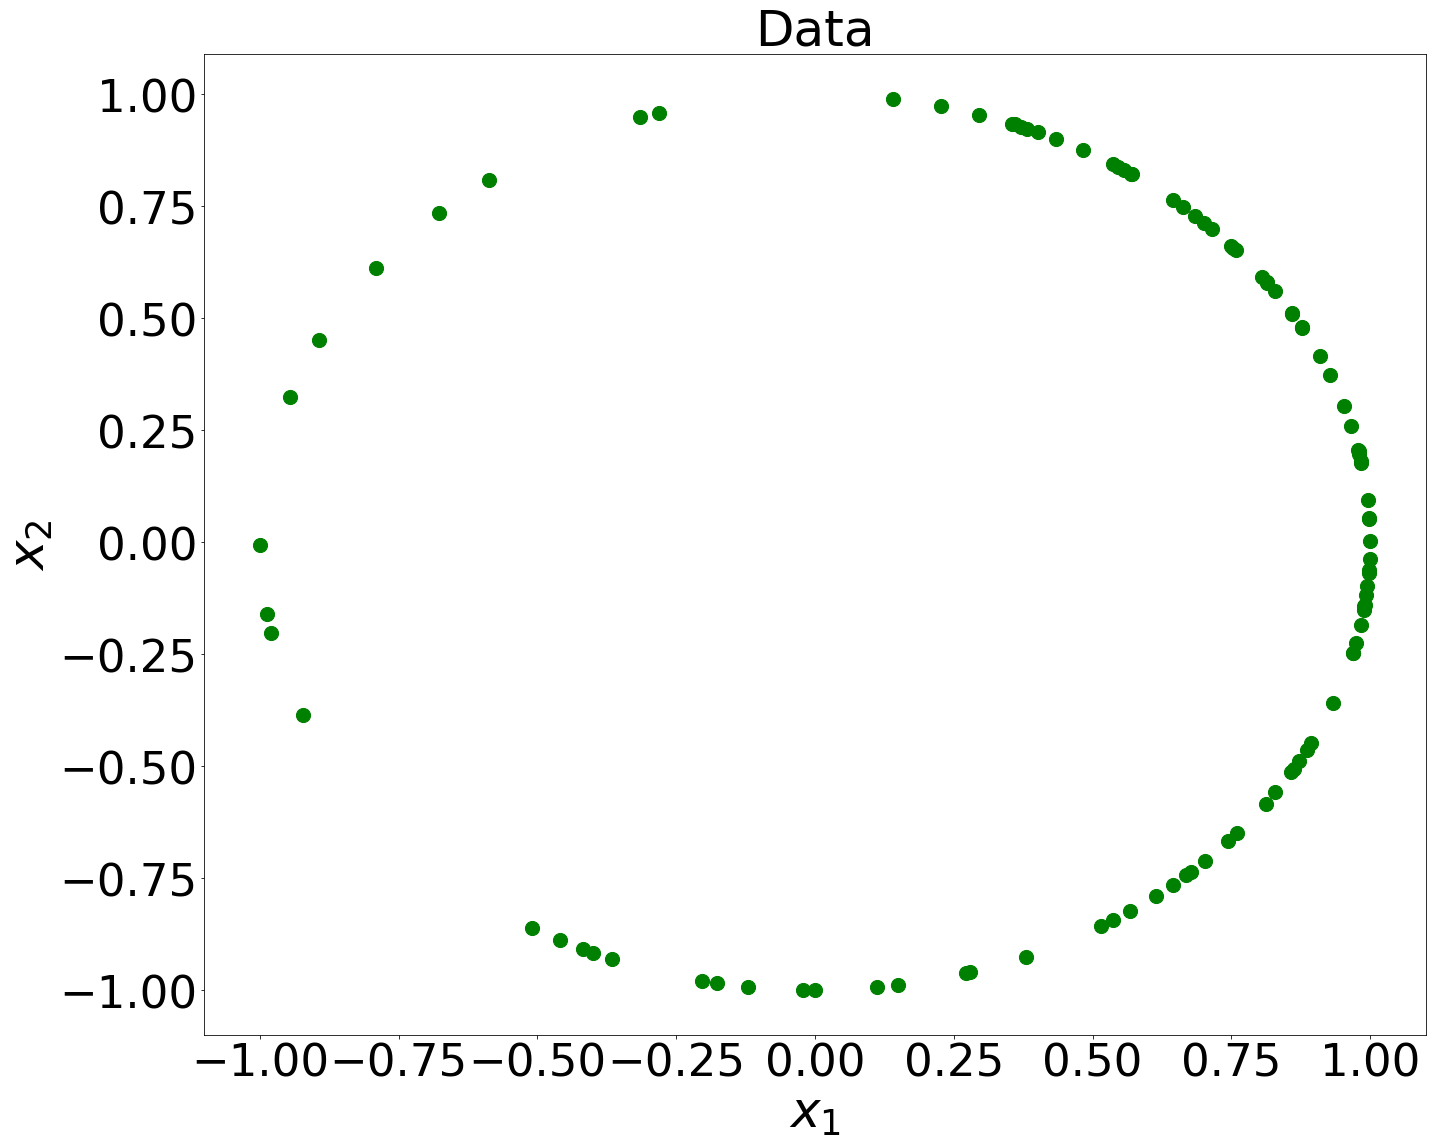

In [4]:
fig, ax = plt.subplots(figsize=(20,16))

plt.scatter(data[:100, 0], data[:100, 1], s=200, c='g')

ax.set_xlabel(r'$x_1$', fontsize=50)
ax.set_ylabel(r'$x_2$', fontsize=50)
ax.tick_params(labelsize=45)
ax.set_title('Data', fontsize=50)

plt.tight_layout()

The first model we train is the EBM. To do so, we define a data loader and set up the components of the model.

In [5]:
data = torch.tensor(data, dtype=torch.float32)
train_loader = DataLoader(data.to('cpu'), batch_size=20)

In [6]:
energy_func = MLP(input_dim=2, hidden_dims=[25, 25], output_dim=1, activation=nn.SiLU)
# NOTE: The EBM below uses the hyperparameters described in the appendix of the paper, and can be improved by
#       changing the standard deviation of the Gaussian noise added during Langevin dynamics from the default of
#       0.005 to 0.5, which we realized after publication while preparing this notebook for public release. This
#       improved model is defined in the commented-out line below, and while this model is better at recovering
#       the circle, it still suffers from manifold overfitting.
ebm = EnergyBasedModel(energy_func=energy_func, x_shape=(2,))
# ebm = EnergyBasedModel(energy_func=energy_func, x_shape=(2,), ld_sigma=0.5)

optim = torch.optim.Adam(ebm.parameters(), lr=0.01)
ebm.optimizer = optim

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optim, lr_lambda=lambda step: 1.)
ebm.lr_scheduler = scheduler

ebm.train()

EnergyBasedModel(
  (energy_func): MLP(
    (net): Sequential(
      (0): Linear(in_features=2, out_features=25, bias=True)
      (1): SiLU()
      (2): Linear(in_features=25, out_features=25, bias=True)
      (3): SiLU()
      (4): Linear(in_features=25, out_features=1, bias=True)
    )
  )
)

We then train the model and plot the learned density. Note that the `for` loop below can be avoided by defining a `SingleTrainer` (class providing functionality to train single-step models in `two_step_zoo/trainers/single_trainer.py`) for the EBM, and calling `train()` on it. This is how we train other models (see `README` for more details). We avoid using `SingleTrainer` here as using this class will automatically log results in a directory, which we find spam-y for a didactic notebook.

In [7]:
for _ in range(100):  # train for 100 epochs
    for batch in train_loader:
        loss = ebm.train_batch(batch, max_grad_norm=1.)
#     print(loss)

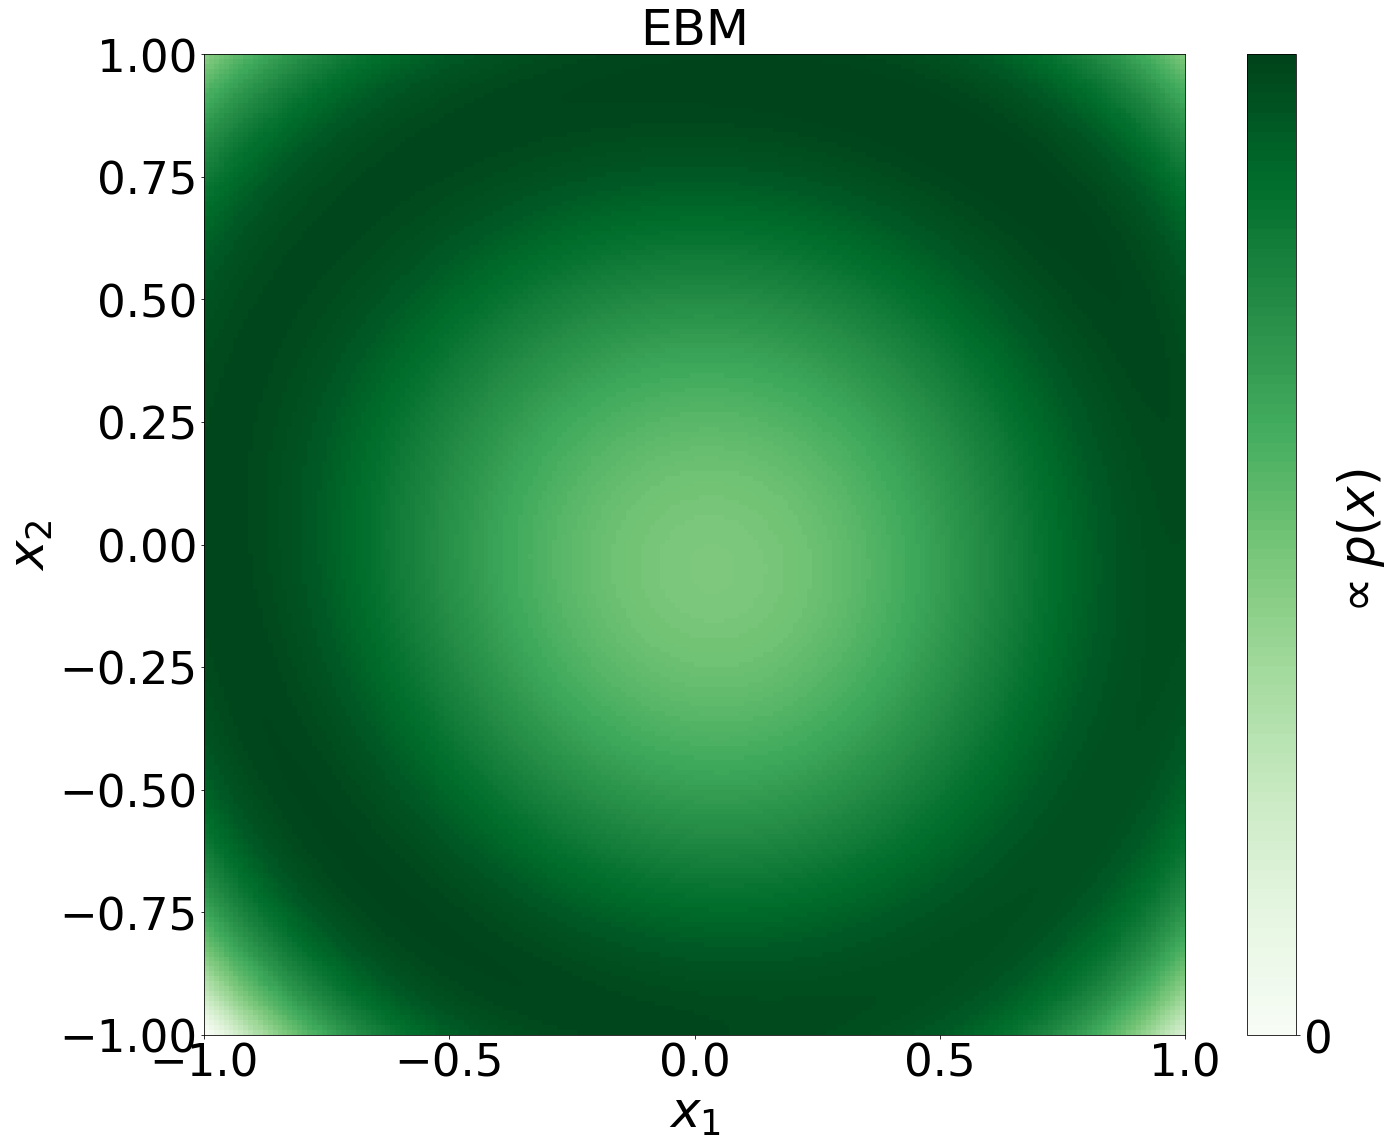

In [8]:
fig, ax = plt.subplots(figsize=(20,16))

# Compute the density (up to a multiplicative constant) that the trained EBM assigns to every point in [-1,1]^2.
x = np.linspace(-1, 1, 200)
y = np.linspace(-1, 1, 200)
xx, yy = np.meshgrid(x,y)
xxyy = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
zz = torch.exp(ebm.log_prob(xxyy)).detach().numpy()

img = zz.reshape((200, 200))
c = plt.cm.Greens(np.linspace(0.0,1.0,101))
cmap = mpl.colors.ListedColormap(c)
plt.imshow(img, cmap=cmap, extent=[-1, 1, -1, 1])

sm = plt.cm.ScalarMappable(cmap=cmap)
cbar = fig.colorbar(sm, ticks=[0])

cbar.ax.set_yticklabels([r'$0$'], fontsize=45)
cbar.ax.set_ylabel(r'$\propto p(x)$', fontsize=50, rotation=90)
ax.set_xlabel(r'$x_1$', fontsize=50)
ax.set_ylabel(r'$x_2$', fontsize=50)
ax.tick_params(labelsize=45)
ax.set_title('EBM', fontsize=50)

plt.tight_layout()

Now we train the AE+EBM model on the same dataset. We begin by defining the AE model.

In [9]:
encoder = MLP(input_dim=2, hidden_dims=[20, 20], output_dim=1, activation=nn.ELU)
decoder = MLP(input_dim=1, hidden_dims=[20, 20], output_dim=2, activation=nn.ELU)

ae = AutoEncoder(latent_dim=1, encoder=encoder, decoder=decoder)

optim2 = torch.optim.Adam(ae.parameters(), lr=0.001)
ae.optimizer = optim2
scheduler2 = torch.optim.lr_scheduler.LambdaLR(optimizer=optim2, lr_lambda=lambda step: 1.)
ae.lr_scheduler = scheduler2

ae.train()

AutoEncoder(
  (encoder): MLP(
    (net): Sequential(
      (0): Linear(in_features=2, out_features=20, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=20, out_features=20, bias=True)
      (3): ELU(alpha=1.0)
      (4): Linear(in_features=20, out_features=1, bias=True)
    )
  )
  (decoder): MLP(
    (net): Sequential(
      (0): Linear(in_features=1, out_features=20, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=20, out_features=20, bias=True)
      (3): ELU(alpha=1.0)
      (4): Linear(in_features=20, out_features=2, bias=True)
    )
  )
)

We then train the AE model. Similarly to the EBM model, the AE model could be trained with a `SingleTrainer` to avoid the `for` loop below. Additionally, this for loop (and the one further down to train the corresponding second-step EBM model) could both be avoided by using a `SequentialTrainer` (from `two_step_zoo/trainers/two_step_trainer.py`) on the AE+EBM model directly (more on this later), which would also produce logs and is how we train other models (see `README`).

In [10]:
for _ in range(200):  # train for 200 epochs
    for batch in train_loader:
        loss = ae.train_batch(batch, max_grad_norm=10.)
#     print(loss)

Once the AE is trained, we produce the dataset of $1$-dimensional representations that we will use to train the second-step EBM. Once again, this step could be avoided through the use of a `SequentialTrainer` (or for that matter with any of the alternating trainers also in `two_step_zoo/trainers/two_step_trainer.py`, which instead of training the EBM only after the AE is completely trained, alternate gradient steps between the two; although we find that sequential training works well).

In [11]:
encoded_data = []
with torch.no_grad():
    for batch in train_loader:
        encoded_batch = ae.encode(batch)
        encoded_data.append(encoded_batch)
    encoded_data = torch.cat(encoded_data)
train_loader2 = DataLoader(encoded_data, batch_size=20)
z_min = float(encoded_data.min().detach().numpy())
z_max = float(encoded_data.max().detach().numpy())

We then define the second-step EBM model.

In [12]:
energy_func2 = MLP(input_dim=1, hidden_dims=[15, 15], output_dim=1, activation=nn.SiLU)
# NOTE: The EBM below uses 0.5 as the standard deviation of the Gaussian noise added during Langevin dynamics,
#       as opposed to 0.005 as described in the appendix of the paper, as this makes Langevin dynamics, and thus
#       EBM training, converge much better.
ebm2 = EnergyBasedModel(energy_func=energy_func2, x_shape=(1,), x_lims=(z_min, z_max), ld_sigma=0.5)

optim3 = torch.optim.Adam(ebm2.parameters(), lr=0.01)
ebm2.optimizer = optim3
scheduler3 = torch.optim.lr_scheduler.LambdaLR(optimizer=optim3, lr_lambda=lambda step: 1.)
ebm2.lr_scheduler = scheduler3

ebm2.train()

EnergyBasedModel(
  (energy_func): MLP(
    (net): Sequential(
      (0): Linear(in_features=1, out_features=15, bias=True)
      (1): SiLU()
      (2): Linear(in_features=15, out_features=15, bias=True)
      (3): SiLU()
      (4): Linear(in_features=15, out_features=1, bias=True)
    )
  )
)

We then train the second-step EBM model, where once again, the `for` loop could be avoided with a `SingleTrainer`.

In [13]:
for _ in range(100):  # train for 100 epochs
    for batch in train_loader2:
        loss = ebm2.train_batch(batch, max_grad_norm=1.0)
#     print(loss)

Once the AE and the second-step EBM are trained, we define the AE+EBM model below, use it to compute the densities on the learned manifold (equation 2 of the paper), and plot the results. As previously mentioned, individual training of the AE and EBM models could have been avoided by defining the AE+EBM model below immediately after defining the AE and EBM models (i.e. without training them), defining a `SequentialTrainer` on the AE+EBM model, and simply calling `train()` on it.

In [14]:
ae_ebm = TwoStepDensityEstimator(generalized_autoencoder=ae, density_estimator=ebm2)  # AE+EBM model

In [15]:
zs = np.linspace(z_min, z_max, 2000).reshape((-1, 1))  # approximate discretization of g(M)
zs_torch = torch.tensor(zs, dtype=torch.float32)
xs = ae_ebm.decode(zs_torch)  # approximate discretization of the learned manifold
log_probs = ae_ebm.log_prob(xs)  # applies (the log of) equation 2 from the manuscript

coords = xs.detach().numpy()
probs = np.exp(log_probs.detach().numpy())

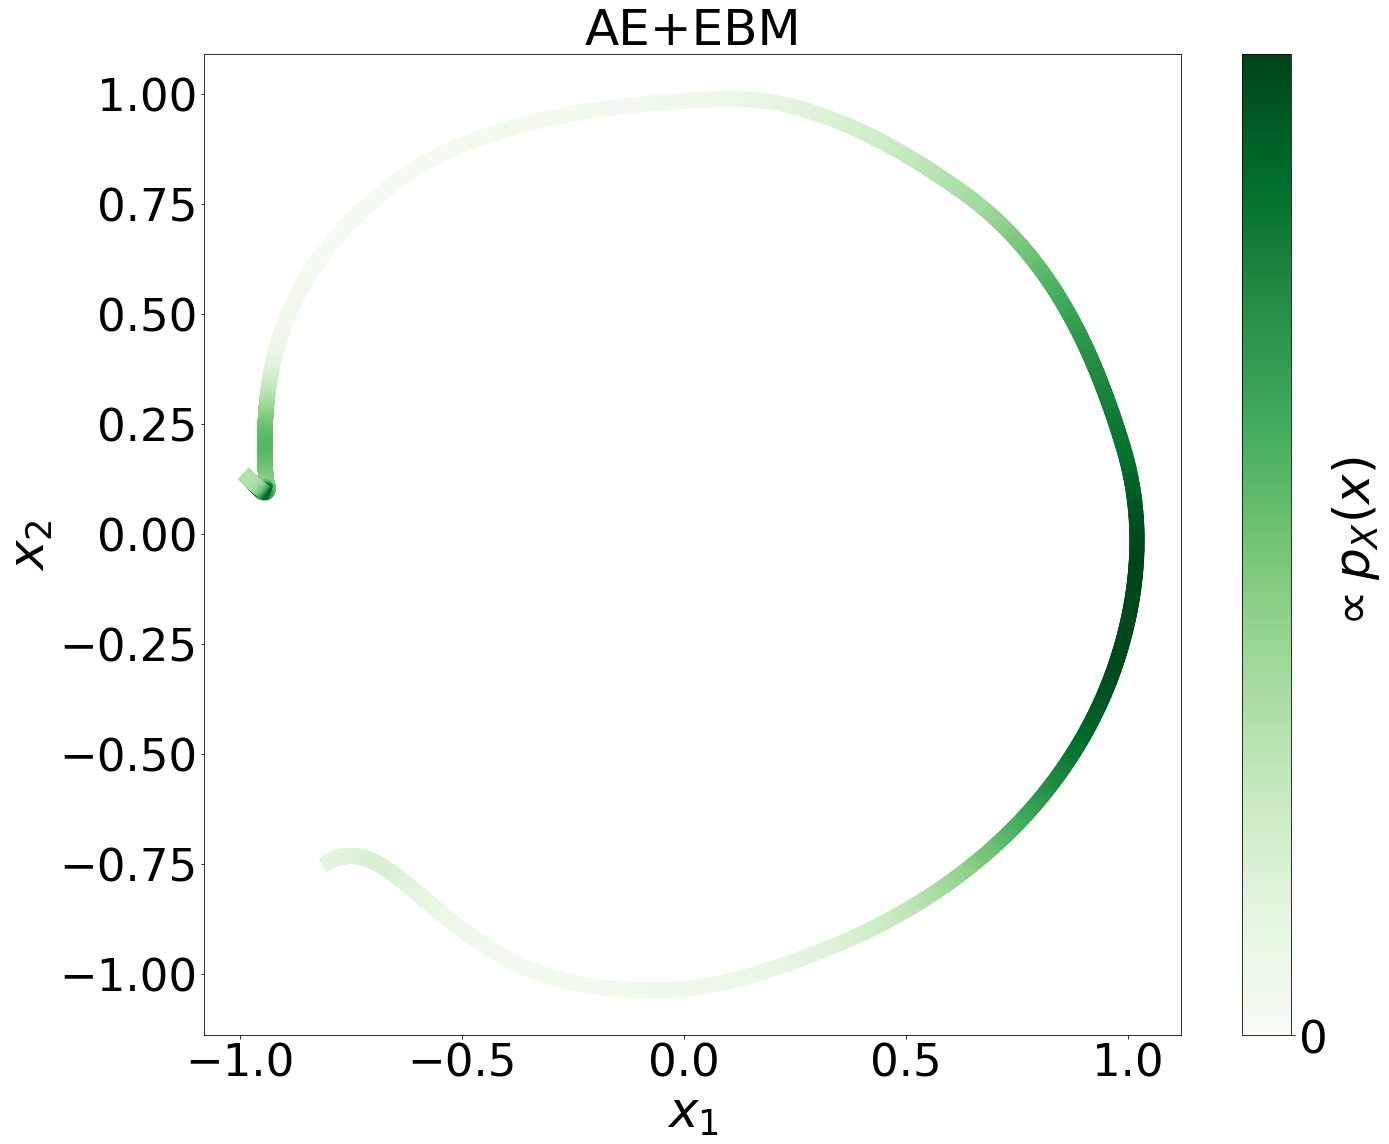

In [16]:
fig, ax = plt.subplots(figsize=(20,16))

c = plt.cm.Greens(np.linspace(0.0, 1.0, 2001))
cmap = mpl.colors.ListedColormap(c)
for i in range(1999):
    j = int(probs[i, 0] / probs.max() * 2000)
    ax.plot(coords[i:i+2, 0], coords[i:i+2, 1], c=c[j], linewidth=15)

sm = plt.cm.ScalarMappable(cmap=cmap)
cbar = fig.colorbar(sm, ticks=[0])

cbar.ax.set_yticklabels([r'$0$'], fontsize=45)
cbar.ax.set_ylabel(r'$\propto p_X(x)$', fontsize=50, rotation=90)
ax.set_xlabel(r'$x_1$', fontsize=50)
ax.set_ylabel(r'$x_2$', fontsize=50)
ax.tick_params(labelsize=45)
ax.set_title(r'AE+EBM', fontsize=50)

plt.tight_layout()